Selected image: /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Training/pituitary_tumor/p (142).jpg
Mean: 0.2080
Std:  0.1589
Min:  0.0000
Max:  1.0000


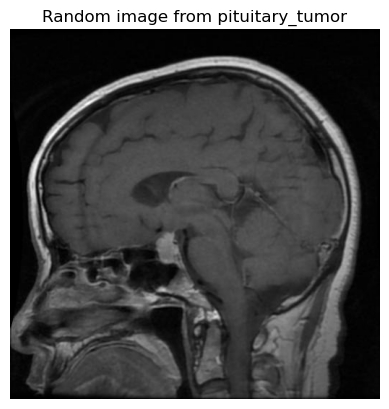

In [6]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#Setting up paths for data
data_root = "/home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification" 

tr_base  = data_root+"/Training"
te_base  = data_root+"/Testing"

# Get subfolders (classes)
subfolders = [os.path.join(tr_base, d) for d in os.listdir(tr_base)
              if os.path.isdir(os.path.join(tr_base, d))]

# Randomly pick a class folder and an image
class_folder = random.choice(subfolders)
img_name = random.choice(os.listdir(class_folder))
img_path = os.path.join(class_folder, img_name)
print(f"Selected image: {img_path}")

# Load and convert to numpy
img = Image.open(img_path)
img_np = np.array(img, dtype=np.float32) / 255.0  # scale to [0, 1]

# Compute statistics
mean = img_np.mean()
std = img_np.std()
min_val = img_np.min()
max_val = img_np.max()

print(f"Mean: {mean:.4f}")
print(f"Std:  {std:.4f}")
print(f"Min:  {min_val:.4f}")
print(f"Max:  {max_val:.4f}")

# Plot
plt.imshow(img_np if img_np.ndim == 3 else img_np, cmap='gray')
plt.title(f"Random image from {os.path.basename(class_folder)}")
plt.axis('off')
plt.show()



In [7]:
#Setting up Transforms 
from pathlib import Path
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler # remember subset when you divide into training and validation
from torchvision import datasets, transforms, utils, models # add models when you import pretrained models for transfer learning
import os
import torch
import numpy as np

IMG_SIZE = 512

def zscore(x):  # MRI-friendly
    return (x - x.mean()) / (x.std() + 1e-8)

train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),                 # use 'RGB' if truly 3-ch
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

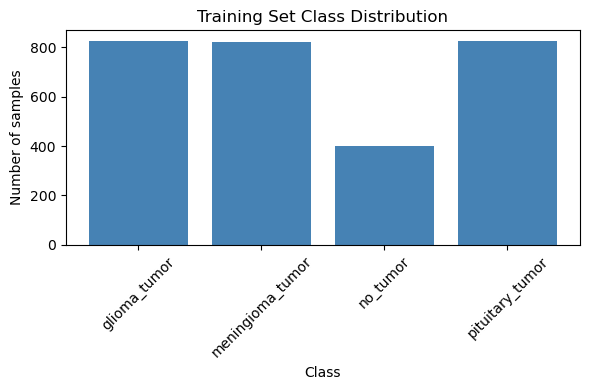

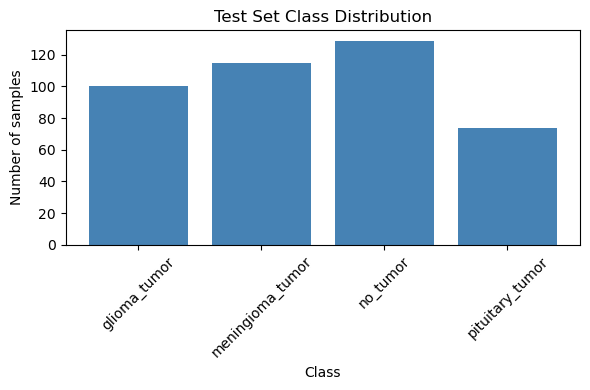

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your datasets are:
trainset=datasets.ImageFolder(tr_base, transform=train_tf)
testset=datasets.ImageFolder(te_base, transform=eval_tf)

def plot_class_distribution(dataset, title):
    labels = np.array(dataset.targets)
    class_names = dataset.classes

    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(6,4))
    plt.bar(class_names, counts, color='steelblue')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(trainset, "Training Set Class Distribution")
plot_class_distribution(testset, "Test Set Class Distribution")


In [8]:
trainset=datasets.ImageFolder(tr_base, transform=train_tf)
valset = datasets.ImageFolder(tr_base, transform=eval_tf)
testset=datasets.ImageFolder(te_base, transform=eval_tf)


print(testset.classes)
print(trainset.classes)
print(valset.classes)

print(len(trainset))
print(len(valset))
print(len(testset))

val_fraction=0.2

idxs = list(range(len(valset)))
rng = np.random.default_rng(42)
rng.shuffle(idxs)

n_val = int(len(idxs) * val_fraction)
val_idx = idxs[:n_val]
train_idx = idxs[n_val:]

trainset = Subset(trainset, train_idx)
valset   = Subset(valset,   val_idx)
print(len(trainset))
print(len(valset))
class_names = datasets.ImageFolder(tr_base).classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
2902
2902
426
2322
580


In [24]:
# validation/test loaders stay standard (no sampler)
val_loader = DataLoader(valset, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)

# Get one batch from the loader
images, labels = next(iter(test_loader))

# Print shapes
print(f"Batch image tensor shape: {images.shape}")
print(f"Batch label tensor shape: {labels.shape}")
print(images[0,0,10:20,10])
#print(images[0,1,10:20,10])
#print(images[0,2,10:20,10])



Batch image tensor shape: torch.Size([100, 1, 512, 512])
Batch label tensor shape: torch.Size([100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [25]:
#okay so it is essentially gray scale!

# Get min and max
print("Min:", images.min().item())
print("Max:", images.max().item())


Min: 0.0
Max: 1.0


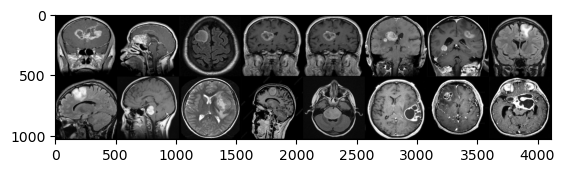

In [27]:
#okay no normalization required

import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.savefig("BrainClasses.png", bbox_inches='tight', pad_inches=0)
    plt.show()

imshow(utils.make_grid(images[0:16]))


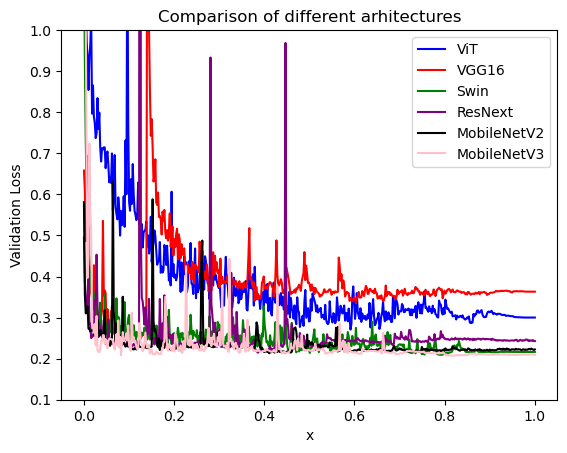

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

filename = "history_ViT.json"
with open(filename, "r") as f:
    data_ViT = json.load(f)

filename = "history_VGG16.json"
with open(filename, "r") as f:
    data_VGG16 = json.load(f)

filename = "history_SwinTranfer.json"
with open(filename, "r") as f:
    data_Swin = json.load(f)

filename = "history_ResNext.json"
with open(filename, "r") as f:
    data_ResNext = json.load(f)

filename = "history_MobileNetV2.json"
with open(filename, "r") as f:
    data_MobileNetV2 = json.load(f)

filename = "history_MobileNetV3.json"
with open(filename, "r") as f:
    data_MobileNetV3 = json.load(f)


filename = "history_MobileNetV2_MTL.json"
with open(filename, "r") as f:
    data_MobileNetV2_MTL = json.load(f)


x = np.linspace(0, 1, 500)
# Plot multiple curves, each with its own color and label
plt.plot(x, data_ViT["val_loss"], color='blue', label='ViT')
plt.plot(x, data_VGG16["val_loss"], color='red', label='VGG16')
plt.plot(x, data_Swin["val_loss"], color='green', label='Swin')
plt.plot(x, data_ResNext["val_loss"], color='purple', label='ResNext')
plt.plot(x, data_MobileNetV2["val_loss"], color='black', label='MobileNetV2')
plt.plot(x, data_MobileNetV3["val_loss"], color='pink', label='MobileNetV3')
#plt.plot(x, data_MobileNetV2_MTL["val_loss"], color='yellow', label='MobileNetV2+MTL')

# Add legend and labels
plt.xlabel("x")
plt.ylabel("Validation Loss")
plt.ylim(0.1, 1)
plt.title("Comparison of different arhitectures")
plt.legend()
plt.show()



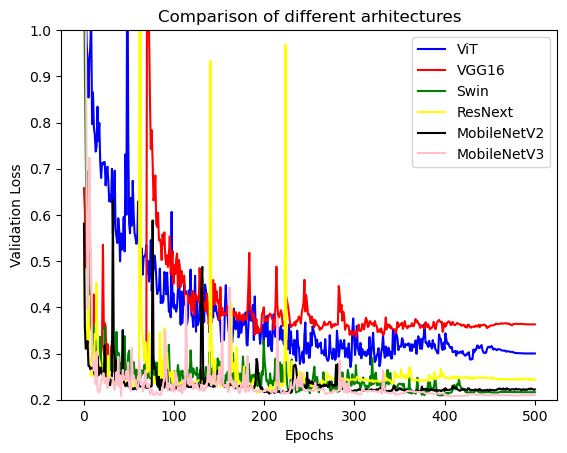

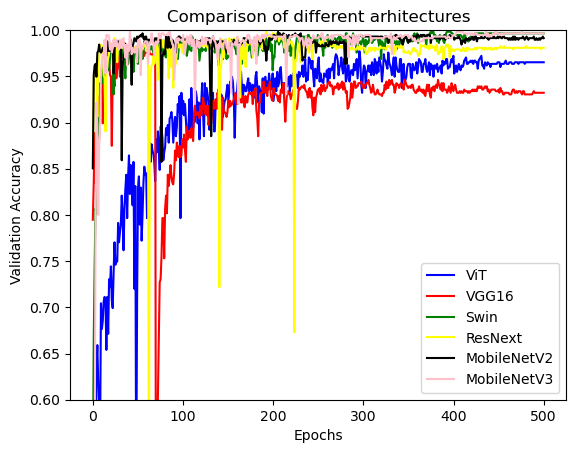

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

filename = "history_ViT.json"
with open(filename, "r") as f:
    data_ViT = json.load(f)

filename = "history_VGG16.json"
with open(filename, "r") as f:
    data_VGG16 = json.load(f)

filename = "history_SwinTranfer.json"
with open(filename, "r") as f:
    data_Swin = json.load(f)

filename = "history_ResNext.json"
with open(filename, "r") as f:
    data_ResNext = json.load(f)

filename = "history_MobileNetV2.json"
with open(filename, "r") as f:
    data_MobileNetV2 = json.load(f)

filename = "history_MobileNetV3.json"
with open(filename, "r") as f:
    data_MobileNetV3 = json.load(f)


filename = "history_MobileNetV2_MTL.json"
with open(filename, "r") as f:
    data_MobileNetV2_MTL = json.load(f)


x = np.linspace(0, 500, 500)
# Plot multiple curves, each with its own color and label
plt.plot(x, data_ViT["val_loss"], color='blue', label='ViT')
plt.plot(x, data_VGG16["val_loss"], color='red', label='VGG16')
plt.plot(x, data_Swin["val_loss"], color='green', label='Swin')
plt.plot(x, data_ResNext["val_loss"], color='yellow', label='ResNext')
plt.plot(x, data_MobileNetV2["val_loss"], color='black', label='MobileNetV2')
plt.plot(x, data_MobileNetV3["val_loss"], color='pink', label='MobileNetV3')
#plt.plot(x, data_MobileNetV2_MTL["val_loss"], color='yellow', label='MobileNetV2+MTL')

# Add legend and labels
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.ylim(0.2, 1)
plt.title("Comparison of different arhitectures")
plt.legend()
plt.savefig("BrainClasses_loss.png", bbox_inches='tight', pad_inches=0)
plt.show()


# Plot multiple curves, each with its own color and label
plt.plot(x, data_ViT["val_acc"], color='blue', label='ViT')
plt.plot(x, data_VGG16["val_acc"], color='red', label='VGG16')
plt.plot(x, data_Swin["val_acc"], color='green', label='Swin')
plt.plot(x, data_ResNext["val_acc"], color='yellow', label='ResNext')
plt.plot(x, data_MobileNetV2["val_acc"], color='black', label='MobileNetV2')
plt.plot(x, data_MobileNetV3["val_acc"], color='pink', label='MobileNetV3')
#plt.plot(x, data_MobileNetV2_MTL["val_acc"], color='yellow', label='MobileNetV2+MTL')

# Add legend and labels
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim(0.6, 1)
plt.title("Comparison of different arhitectures")
plt.legend()
plt.savefig("BrainClasses_accuracy.png", bbox_inches='tight', pad_inches=0)
plt.show()





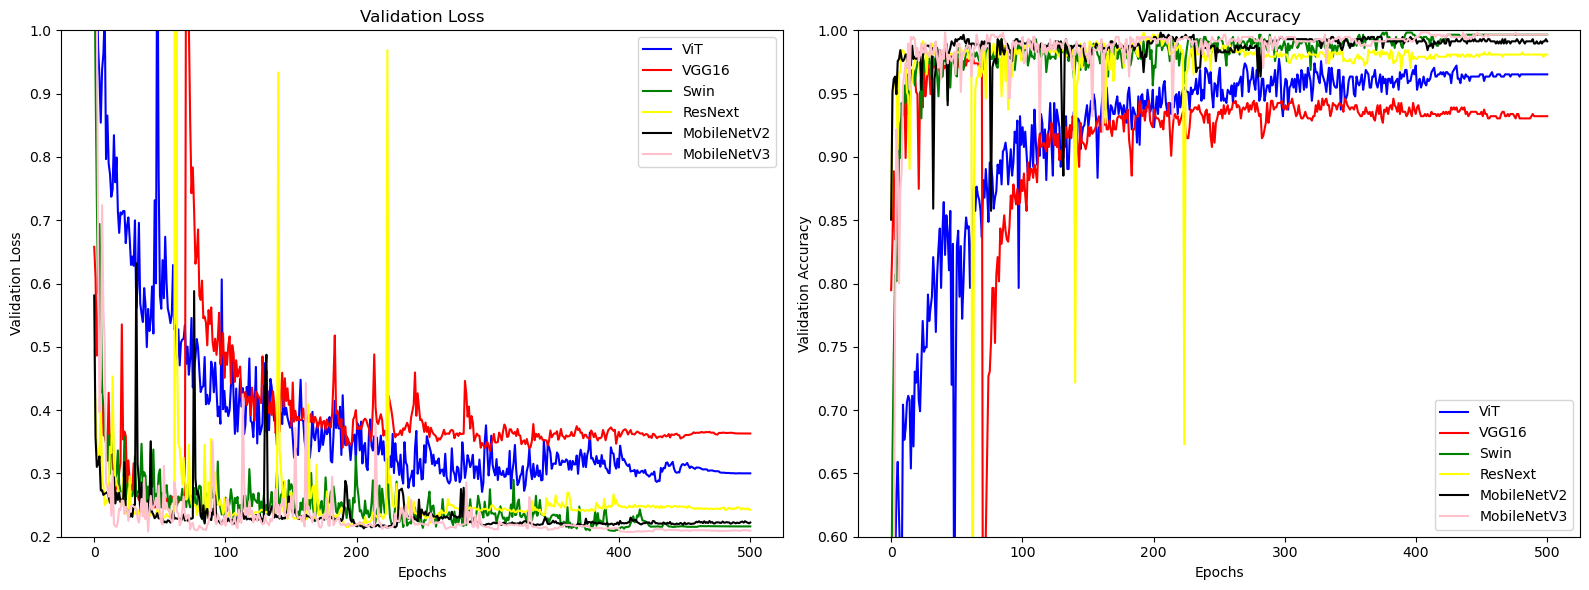

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np

# --- Load JSON histories ---
def load_history(fname):
    with open(fname, "r") as f:
        return json.load(f)

data_ViT          = load_history("history_ViT.json")
data_VGG16        = load_history("history_VGG16.json")
data_Swin         = load_history("history_SwinTranfer.json")
data_ResNext      = load_history("history_ResNext.json")
data_MobileNetV2  = load_history("history_MobileNetV2.json")
data_MobileNetV3  = load_history("history_MobileNetV3.json")
data_MobileNetV2_MTL = load_history("history_MobileNetV2_MTL.json")

# Epoch axis
x = np.linspace(0, 500, 500)

# --- Create subplots: 1 row, 2 columns ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# ==========================
# Plot 1 — Validation Loss
# ==========================
ax = axs[0]
ax.plot(x, data_ViT["val_loss"], color='blue', label='ViT')
ax.plot(x, data_VGG16["val_loss"], color='red', label='VGG16')
ax.plot(x, data_Swin["val_loss"], color='green', label='Swin')
ax.plot(x, data_ResNext["val_loss"], color='yellow', label='ResNext')
ax.plot(x, data_MobileNetV2["val_loss"], color='black', label='MobileNetV2')
ax.plot(x, data_MobileNetV3["val_loss"], color='pink', label='MobileNetV3')
# ax.plot(x, data_MobileNetV2_MTL["val_loss"], color='orange', label='MobileNetV2+MTL')

ax.set_xlabel("Epochs")
ax.set_ylabel("Validation Loss")
ax.set_ylim(0.2, 1)
ax.set_title("Validation Loss")
ax.legend()

# ==========================
# Plot 2 — Validation Accuracy
# ==========================
ax = axs[1]
ax.plot(x, data_ViT["val_acc"], color='blue', label='ViT')
ax.plot(x, data_VGG16["val_acc"], color='red', label='VGG16')
ax.plot(x, data_Swin["val_acc"], color='green', label='Swin')
ax.plot(x, data_ResNext["val_acc"], color='yellow', label='ResNext')
ax.plot(x, data_MobileNetV2["val_acc"], color='black', label='MobileNetV2')
ax.plot(x, data_MobileNetV3["val_acc"], color='pink', label='MobileNetV3')
# ax.plot(x, data_MobileNetV2_MTL["val_acc"], color='orange', label='MobileNetV2+MTL')

ax.set_xlabel("Epochs")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim(0.6, 1)
ax.set_title("Validation Accuracy")
ax.legend()

# Tight layout + save
plt.tight_layout()
plt.savefig("BrainClasses_loss_accuracy_subplot.png", bbox_inches='tight', pad_inches=0)
plt.show()
